In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import RNN, Layer
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow import float32, concat, convert_to_tensor, linalg
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

class RungeKuttaIntegratorCell(Layer):
    def __init__(self, m, c, k, dt, initial_state, **kwargs):
        super(RungeKuttaIntegratorCell, self).__init__(**kwargs)
        self.Minv = linalg.inv(np.diag(m))
        self._c   = c
        self.K    = self._getCKmatrix(k)
        self.initial_state = initial_state
        self.state_size    = 2*len(m)
        self.A  = np.array([0., 0.5, 0.5, 1.0], dtype='float32')
        self.B  = np.array([[1/6, 2/6, 2/6, 1/6]], dtype='float32')
        self.dt = dt

    def build(self, input_shape, **kwargs):
        self.kernel = self.add_weight("C", shape = self._c.shape, trainable = True, initializer = lambda shape, dtype: self._c, **kwargs)
        self.built  = True

    def call(self, inputs, states):
        C    = self._getCKmatrix(self.kernel)
        y    = states[0][:,:1]
        ydot = states[0][:,1:]
        print("Shape of the State: ",len(states)," ",len(states[0])," ",len(states[0][0]),"\n")
        print("current C value: ",C)
        print(inputs,"        Shape of the inputs: ",len(inputs),len(inputs[0]))
        
        yddoti = self._fun(self.Minv, self.K, C, inputs, y, ydot)
        yi     = y + self.A[0] * ydot * self.dt
        ydoti  = ydot + self.A[0] * yddoti * self.dt
        fn     = self._fun(self.Minv, self.K, C, inputs, yi, ydoti)
        for j in range(1,4):
            yn    = y + self.A[j] * ydot * self.dt
            ydotn = ydot + self.A[j] * yddoti * self.dt
            ydoti = concat([ydoti, ydotn], axis=0)
            fn    = concat([fn, self._fun(self.Minv, self.K, C, inputs, yn, ydotn)], axis=0)

        y    = y + linalg.matmul(self.B, ydoti) * self.dt
        ydot = ydot + linalg.matmul(self.B, fn) * self.dt
        return y, [concat(([y, ydot]), axis=-1)]

    def _fun(self, Minv, K, C, u, y, ydot):
        return linalg.matmul(u - linalg.matmul(ydot, C, transpose_b=True) - linalg.matmul(y, K, transpose_b=True), Minv, transpose_b=True)
                             
    def _getCKmatrix(self, a):
        return convert_to_tensor([[a[0]]], dtype=float32)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return self.initial_state

In [4]:
a = tf.constant(np.arange(1, 2, dtype=np.int32), shape=[1,1])
print(a)
b = tf.constant(np.arange(5, 6, dtype=np.int32), shape=[1,1])
print(b)
print(linalg.matmul(a,b))
a1=np.arange(1,2,dtype=np.int32).reshape((1,1))
print(a1)
b1=np.arange(5,6,dtype=np.int32).reshape((1,1))
print(b1)
print(tf.constant(a1))
print(tf.constant(np.matmul(a1,b1)))
#print(linalg.inv(np.diag(m)))
# print(linalg.matmul(, C, transpose_b=True))

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[5]], shape=(1, 1), dtype=int32)
tf.Tensor([[5]], shape=(1, 1), dtype=int32)
[[1]]
[[5]]
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[5]], shape=(1, 1), dtype=int32)


In [5]:

def create_model(m, c, k, dt, initial_state, batch_input_shape, return_sequences = True, unroll = False):
    rkCell = RungeKuttaIntegratorCell(m=m, c=c, k=k, dt=dt, initial_state=initial_state)
    PINN   = RNN(cell=rkCell, batch_input_shape=batch_input_shape, return_sequences=return_sequences, return_state=False, unroll=unroll)
    model  = Sequential()
    model.add(PINN)
   
    model.compile(loss='mse', optimizer=RMSprop(0.01), metrics=['mae'])
    return model

In [6]:
 # masses, spring coefficients, and damping coefficients
m = np.array([200/386], dtype='float32')
c = np.array([1], dtype='float32') # initial guess
k = np.array([20.4], dtype='float32')

In [7]:
# data
df = pd.read_csv('/content/drive/MyDrive/Major Project/New/Data/Training Datasets/phy/1dof_newbarks - Sheet1.csv')
t = df[['t']].values
dt=0.02

utrain = df[['u']].values[np.newaxis, :, :]*(200)
ytrain = df[['y']].values[np.newaxis, :, :]*-1
noise_y = (5/100)*np.amax(ytrain)*np.random.normal(0, 1, ytrain.shape)
ytrain=ytrain+noise_y
# print(df.describe)


In [8]:
np.amax(ytrain)

6.031140496936477

(1, 1560, 1) (1, 1560, 1)


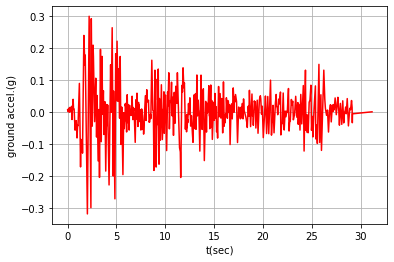

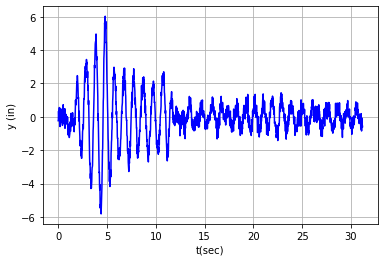

In [9]:
print(ytrain.shape,utrain.shape)
plt.figure()
plt.plot( t,utrain[0, :, :]/200, 'r',label='m1')
plt.xlabel('t(sec)')
plt.ylabel('ground accel.(g)')
plt.grid('on')

plt.figure()
plt.plot( t,ytrain[0, :, :], 'b',label='y1')
plt.xlabel('t(sec)')
plt.ylabel('y (in)')
plt.grid('on')

In [10]:
    # fitting physics-informed neural network
initial_state =np.zeros((1,2 * len(m),), dtype='float32')
model = create_model(m, c, k, dt, initial_state=initial_state, batch_input_shape=utrain.shape)
print(model.summary())
yPred_before = model.predict_on_batch(utrain)[0, :, :]
history = model.fit(utrain, ytrain, epochs=90, steps_per_epoch=1, verbose=1)
yPred   = model.predict_on_batch(utrain)[0, :, :]

Shape of the State:  1   1   2 

current C value:  Tensor("rnn/runge_kutta_integrator_cell/packed:0", shape=(1, 1), dtype=float32)
Tensor("rnn/strided_slice_2:0", shape=(1, 1), dtype=float32)         Shape of the inputs:  1 1
Shape of the State:  1   1   2 

current C value:  Tensor("rnn/while/runge_kutta_integrator_cell/packed:0", shape=(1, 1), dtype=float32)
Tensor("rnn/while/TensorArrayV2Read/TensorListGetItem:0", shape=(1, 1), dtype=float32)         Shape of the inputs:  1 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (1, 1560, 1)              1         
                                                                 
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________
None
Shape of the State:  1   1   2 

current C value:  Tensor("sequential/rnn/runge_kutta_integrator_cell

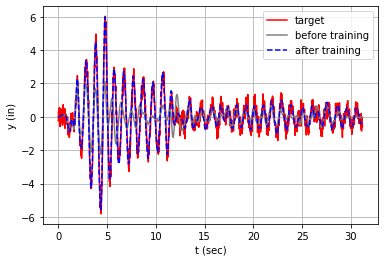

In [11]:
    # plotting prediction results
plt.plot( t,ytrain[0, :, :], 'r',label='target')
plt.plot( t,yPred_before[:, :], 'gray', label='before training')
plt.plot( t,yPred[:, :], 'b--', label='after training')
plt.xlabel('t (sec)')
plt.ylabel('y (in)')
plt.grid('on')
plt.legend()
plt.show()

In [12]:
df = pd.read_csv('/content/drive/MyDrive/Major Project/New/Data/Training Datasets/phy/newbarks_u_02 - Sheet1.csv')
t  = df[['t']].values
dt=0.02
xval = df[['u']].values[np.newaxis, :1560, :]*(200)
yval = df[['y']].values[np.newaxis, :1560, :]*-1
noise_y = (5/100)*np.amax(yval)*np.random.normal(0, 1, yval.shape)
yval=yval+noise_y

ypred=model.predict(xval)
model.evaluate(ypred,yval)

Shape of the State:  1   1   2 

current C value:  Tensor("sequential/rnn/runge_kutta_integrator_cell/packed:0", shape=(1, 1), dtype=float32)
Tensor("sequential/rnn/strided_slice_2:0", shape=(1, 1), dtype=float32)         Shape of the inputs:  1 1
Shape of the State:  1   1   2 

current C value:  Tensor("sequential/rnn/while/runge_kutta_integrator_cell/packed:0", shape=(1, 1), dtype=float32)
Tensor("sequential/rnn/while/TensorArrayV2Read/TensorListGetItem:0", shape=(1, 1), dtype=float32)         Shape of the inputs:  1 1
Shape of the State:  1   1   2 

current C value:  Tensor("sequential/rnn/runge_kutta_integrator_cell/packed:0", shape=(1, 1), dtype=float32)
Tensor("sequential/rnn/strided_slice_2:0", shape=(1, 1), dtype=float32)         Shape of the inputs:  1 1
Shape of the State:  1   1   2 

current C value:  Tensor("sequential/rnn/while/runge_kutta_integrator_cell/packed:0", shape=(1, 1), dtype=float32)
Tensor("sequential/rnn/while/TensorArrayV2Read/TensorListGetItem:0", shape=(

[1.5502654314041138, 1.0416325330734253]

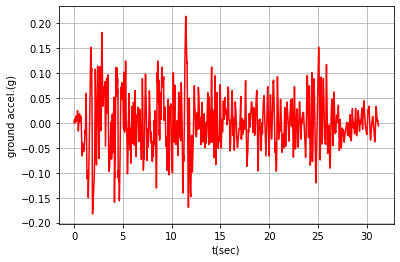

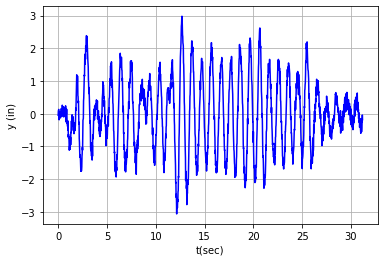

In [13]:
plt.figure()
plt.plot( t[:1560],xval[0, :, :]/200, 'r',label='m1')
plt.xlabel('t(sec)')
plt.ylabel('ground accel.(g)')
plt.grid('on')

plt.figure()
plt.plot( t[:1560],yval[0, :, :], 'b',label='y1')
plt.xlabel('t(sec)')
plt.ylabel('y (in)')
plt.grid('on')

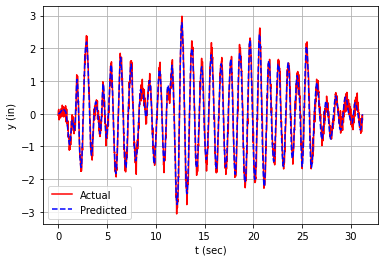

In [14]:
plt.plot(t[:1560], yval[0, :, :], 'r',label='Actual')
plt.plot( t[:1560],ypred[0,:, :], 'b--', label='Predicted')
plt.xlabel('t (sec)')
plt.ylabel('y (in)')
plt.grid('on')
plt.legend()
plt.show()

In [15]:
print(model.layers[0].get_weights()[0])

[0.1328573]
